# Conv1D Autoencoder를 사용한 시계열 data 이상 감지
시계열 자료의 이상치 검출

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Dropout, Conv1DTranspose
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

## Load the data

비정상적인 동작 기간이 labeling 된  인공 시계열 데이터
[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) 를 사용합니다. 데이터는 정열되고 타임스탬프가 지정된 단일 값 메트릭입니다.

학습에는 noise가 포함된 정상 시계열 데이터인인 `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 이상치가 포함된 `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# 훈련 세트 URL 접미사를 설정합니다.
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"

# 훈련 세트의 전체 URL을 생성합니다.
df_small_noise_url = master_url_root + df_small_noise_url_suffix

# 훈련 세트 데이터를 불러옵니다.
# parse_dates=True를 사용하여 'timestamp' 열을 날짜 형식으로 파싱합니다.
# index_col="timestamp"를 사용하여 'timestamp' 열을 인덱스로 설정합니다.
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

# 테스트 세트 URL 접미사를 설정합니다.
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"

# 테스트 세트의 전체 URL을 생성합니다.
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix

# 테스트 세트 데이터를 불러옵니다.
# parse_dates=True를 사용하여 'timestamp' 열을 날짜 형식으로 파싱합니다.
# index_col="timestamp"를 사용하여 'timestamp' 열을 인덱스로 설정합니다.
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

# 훈련 세트와 테스트 세트의 형태(shape)를 출력합니다.
print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [3]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## data 시각화
### noise 가 포함된 정상 시계열 데이터

- 정상 데이터를 autoencoder 훈련에 사용합니다.

<Axes: xlabel='timestamp'>

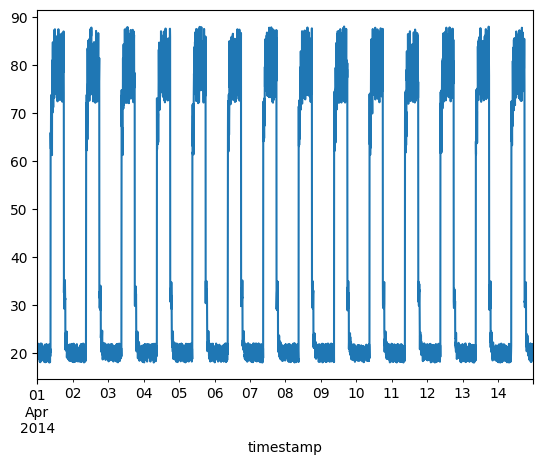

In [5]:
df_small_noise.plot(legend=False)

### 이상치가 있는 시계열 데이터

정상 데이터로 훈련된 autoencoder 모델의 테스트를 위해 다음 데이터를 사용하고, 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

<Axes: xlabel='timestamp'>

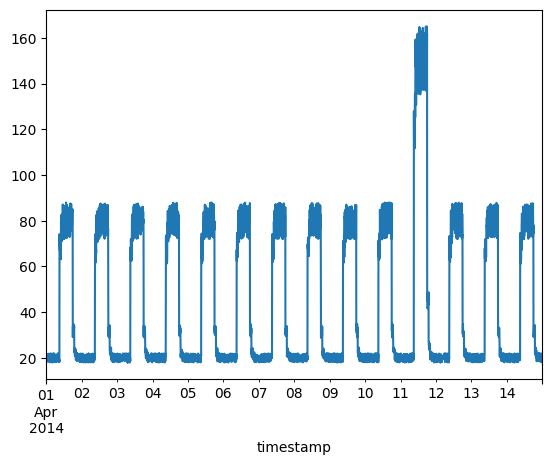

In [6]:
df_daily_jumpsup.plot(legend=False)

## 훈련 데이터 준비

훈련 시계열 데이터 파일(`df_small_noise`)에서 데이터 값을 가져오고 `value` 데이터를 정규화 합니다. 14일 동안 5분마다 `value`가 있습니다.

-   24시간 * 60분 / 5분 = **288 timesteps per day**
-   288 timesteps per day * 14일 = **total 4032 data points**

In [7]:
# 테스트 데이터를 정규화하기 위해 평균과 표준 편차를 정규화하고 저장합니다.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
# standard scaling
df_training_value = (df_small_noise - training_mean) / training_std

print("훈련 샘플 수:", len(df_training_value))

훈련 샘플 수: 4032


In [9]:
# normalize된 df_small_noise
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


### 시퀀스 data 생성

훈련 데이터에서 `TIME_STEPS` 연속 데이터 값을 조합하여 시퀀스를 생성합니다.

In [10]:
# 타임 스텝의 개수를 288로 설정합니다.
TIME_STEPS = 288

# 주어진 값으로부터 시퀀스를 생성하는 함수입니다.
# 모델에서 사용하기 위해 훈련 시퀀스를 생성합니다.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    # values 배열에서 time_steps 길이의 시퀀스를 생성합니다.
    for i in range(len(values) - time_steps + 1):
        # 각 시퀀스를 output 리스트에 추가합니다.
        output.append(values[i : (i + time_steps)])
    # 리스트를 numpy 배열로 변환하여 반환합니다.
    return np.stack(output)

# 훈련 데이터를 시퀀스로 변환합니다.
X_train = create_sequences(df_training_value.values)

# 변환된 훈련 데이터의 형태를 출력합니다.
print("Training input shape: ", X_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

컨볼루션 재구성 오토인코더 모델을 구축합니다. 모델은 `(batch_size, sequence_length, num_features)`  shape의 입력을 받고 동일한 shape의 출력을 반환합니다. 이 경우 `sequence_length`는 288이고 `num_features`는 1입니다.

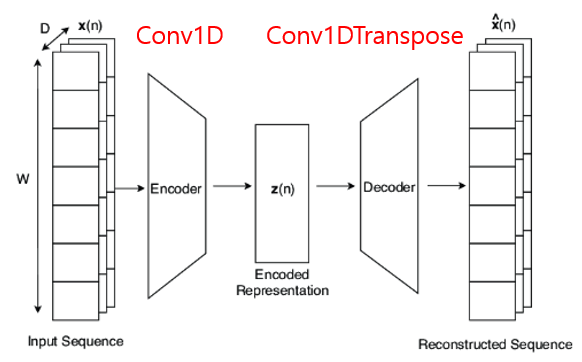

In [13]:
# 첫 번째 차원의 크기(시퀀스의 길이), 두 번째 차원의 크기(특성의 수)를 출력합니다.
X_train.shape[1],  X_train.shape[2]

(288, 1)

In [15]:
model = keras.Sequential([
    # 입력 데이터의 형태 - (시퀀스 길이, 특성 수)
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # 첫 번째 1D 컨볼루션 레이어
    Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    # 드롭아웃 레이어를 추가하여 과적합을 방지합니다.
    Dropout(rate=0.2),

    # 두 번째 1D 컨볼루션 레이어
    Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),

    # 첫 번째 1D 트랜스포즈 컨볼루션 레이어
    Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),

    # 두 번째 1D 트랜스포즈 컨볼루션 레이어.
    Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),

    # 마지막 1D 트랜스포즈 컨볼루션 레이어를 추가
    Conv1DTranspose(filters=1, kernel_size=1, padding="same"),
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │            33 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,313 (36.38 KB)

 Trainable params: 9,313 (36.38 KB)

 Non-trainable params: 0 (0.00 B)

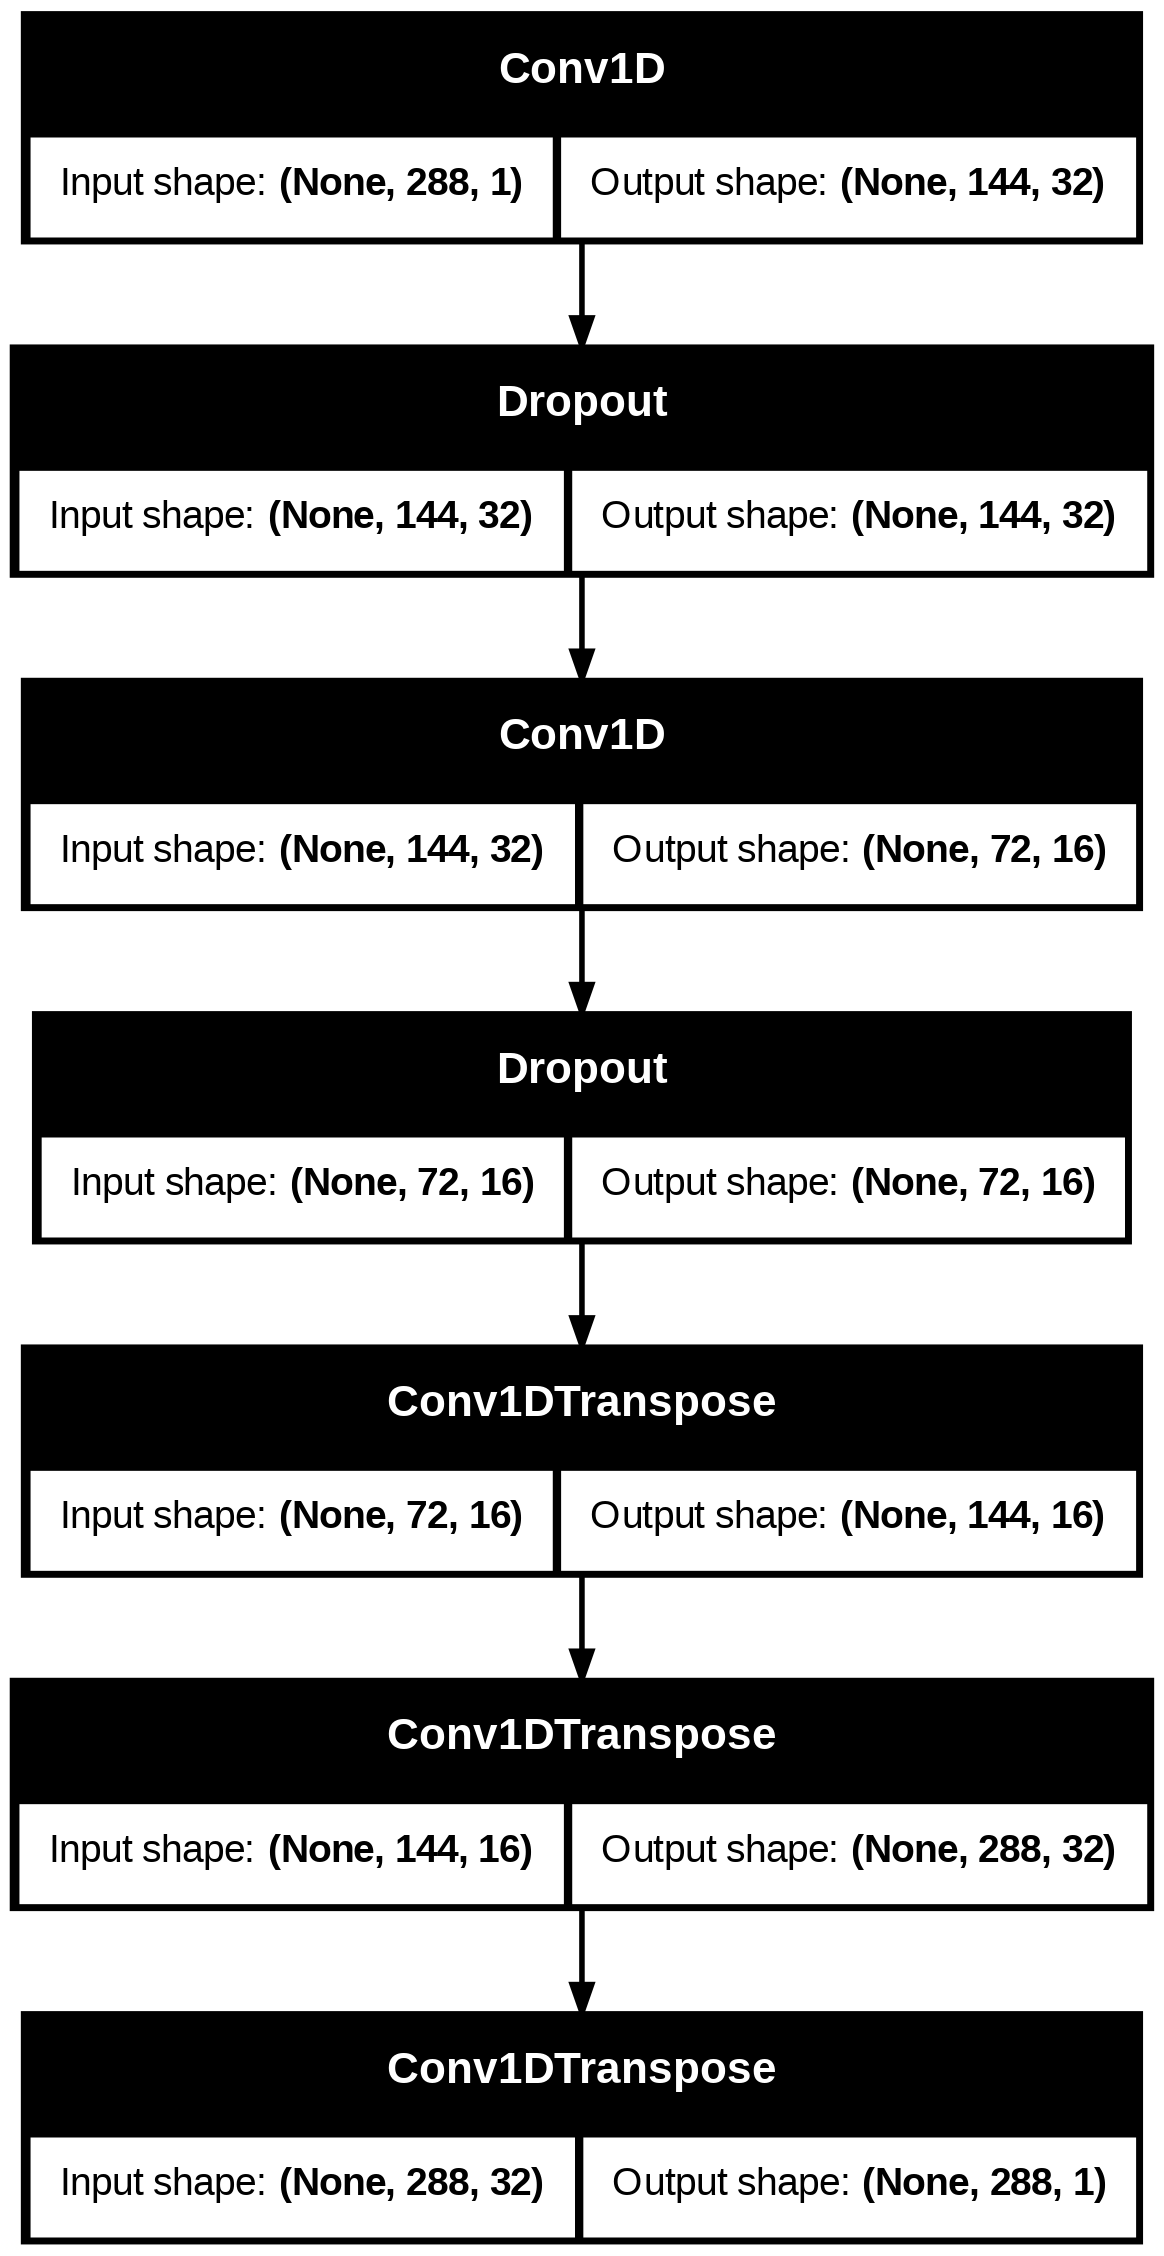

In [16]:
plot_model(model, show_shapes=True)

## 모델 train

재구성 모델이기 때문에 Input과 Target 모두 `X_train`을 사용합니다.

In [17]:
history = model.fit(
    X_train, X_train,         # 입력 데이터와 타겟 데이터를 동일하게 설정
    epochs=50,
    batch_size=128,
    validation_split=0.1,    # 훈련 데이터의 10%를 검증 데이터로 사용합니다.
    callbacks=[
        # 검증 손실(val_loss)을 모니터링하고, 개선이 없을 경우 훈련을 조기에 종료합니다.
        # patience=5: 검증 손실이 개선되지 않으면 5 에포크 후 훈련을 중지합니다.
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.7870 - val_loss: 0.3039
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1663 - val_loss: 0.0535
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0631 - val_loss: 0.0379
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0540 - val_loss: 0.0336
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - val_loss: 0.0311
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0435 - val_loss: 0.0289
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394 - val_loss: 0.0274
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - val_loss: 0.0265
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - val_loss: 0.0259
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - val_loss: 0.0258
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0286 - val_loss: 0.0276
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0270 - val

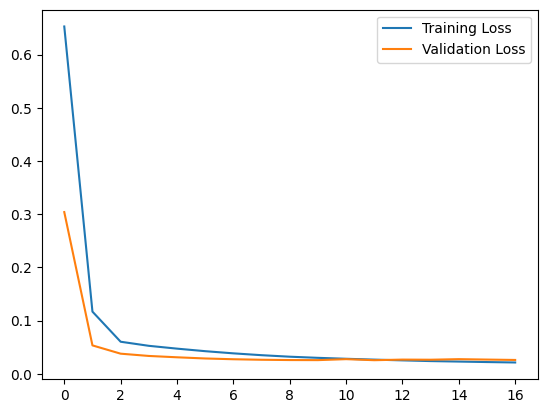

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 감지

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1.   훈련 샘플에서 MAE 손실을 찾습니다.
2.   최대 MAE 손실 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 이를 이상 감지의 `threshold`로 설정합니다.
3.   샘플의 재구성 손실이 이 `threshold` 보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 `anomaly`로 분류할 것입니다.

- MAE 손실 시각화

| 항목     | MAE (Mean Absolute Error)     | MSE (Mean Squared Error) |   |                                                |
| ------ | ----------------------------- | ------------------------ | - | ---------------------------------------------- |
| 계산식    | $(\text{MAE} = \frac{1}{n}\sum | x - \hat{x}              | )$ | $\text{MSE} = \frac{1}{n}\sum (x - \hat{x})^2$ |
| 단위     | 입력과 동일                        | 제곱 단위 (스케일 커짐)           |   |                                                |
| 이상치 영향 | **작음** (선형 증가)                | **큼** (제곱으로 크게 벌어짐)      |   |                                                |
| 분포 해석  | 더 직관적, 실제 평균 오차               | 큰 오차에 민감, 이상치 강조         |   |                                                |
| 시각화    | 히스토그램이 더 깔끔                   | 스케일이 커서 꼬리가 길어짐          |   |                                                |

- MAE → 분포를 직관적으로 보고 threshold 정하기 좋음

- MSE → 큰 이상치 차이를 더 부각시켜 anomaly detection 성능을 높일 때 사용 (threshold 튜닝 필요)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


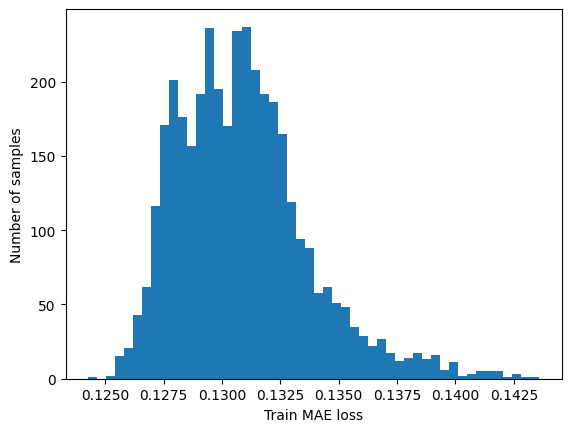

In [20]:
# 모델을 사용하여 훈련 데이터에 대한 예측값을 생성합니다.
X_train_pred = model.predict(X_train)

# 훈련 데이터와 예측값 사이의 MAE(Mean Absolute Error) 손실을 계산합니다.
# np.abs(X_train_pred - X_train)은 절대 오차를 계산합니다.
# np.mean(..., axis=1)은 각 샘플에 대해 평균 절대 오차를 계산합니다.
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# 훈련 데이터의 MAE 손실을 히스토그램으로 시각화합니다.
plt.hist(train_mae_loss, bins=50)

# x축 레이블을 설정합니다.
plt.xlabel("Train MAE loss")

# y축 레이블을 설정합니다.
plt.ylabel("Number of samples")

# 그래프를 화면에 표시합니다.
plt.show()

- train set의 최대 MAE 손실을 재구성 손실 임계값으로 정합니다.

In [21]:
threshold = np.max(train_mae_loss)
print("재구성 오류 임계값: ", threshold)

재구성 오류 임계값:  0.14358416594761783


### 재구성 비교

우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 봅니다.
이것은 훈련 데이터 세트 1일차의 288개 timestep 입니다.

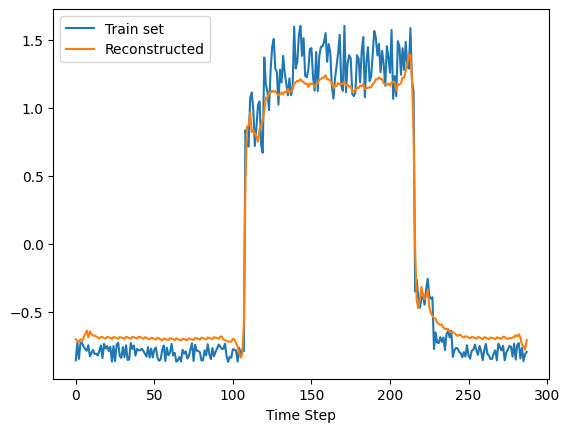

In [22]:
# 첫 번째 시퀀스가  어떻게 학습되었는지 확인
plt.plot(X_train[0], label='Train set')
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel("Time Step")
plt.legend()

### 테스트 데이터 준비
- Test set을 standard scale   
- 분포가 바뀌면 안되므로 Train set 에서 구해 놓았던 평균과 표준 편차를 그대로 사용
- 시각화

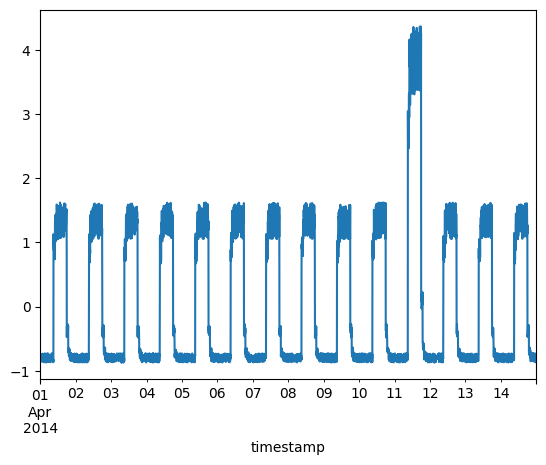

In [23]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

- Test set에서 시계열 시퀀스 data 생성

In [24]:
X_test = create_sequences(df_test_value.values)
print("Test input shape: ", X_test.shape)

Test input shape:  (3745, 288, 1)


- Test set의 MAE loss 구하기

In [25]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


- MAE 손실 시각화

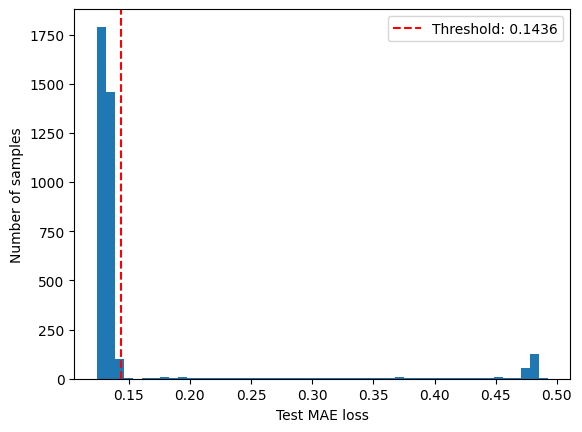

In [26]:
# 테스트 데이터의 MAE 손실을 히스토그램으로 시각화합니다.
plt.hist(test_mae_loss, bins=50)

# x축 레이블을 설정합니다.
plt.xlabel("Test MAE loss")
# y축 레이블을 설정합니다.
plt.ylabel("Number of samples")

# threshold 값을 수직선으로 표시합니다.
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')

plt.legend()
plt.show()

- 모든 이상 샘플 감지  
- train set의 최대 MAE 손실에서 구했던 threshold 사용

In [27]:
anomalies = test_mae_loss > threshold
print("이상 감지된 샘플 수: ", np.sum(anomalies))
print("이상 감지된 샘플의 인덱스: ", np.where(anomalies))

이상 감지된 샘플 수:  416
이상 감지된 샘플의 인덱스:  (array([ 213,  788,  789,  790,  969, 1649, 1650, 1651, 1652, 1653, 1654,
       1658, 1659, 1833, 1941, 1942, 1946, 2517, 2522, 2523, 2697, 2701,
       2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 28

## 이상치 plot

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 `timestamps`를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `X_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 마지막 time_steps-1 데이터 값을 제외한 모든 값은 `time_steps` 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상이라는 것을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.  

그러므로 `TIME_STEPS`기간 전체 샘플 `[(i - timesteps + 1) ~ (i)]`이 비정상인 경우 데이터 `i`는 비정상으로 분류할 수 있습니다.

In [28]:
# 비정상 데이터의 시작 인덱스를 설정합니다.
index = 2754

print(index, index + TIME_STEPS)

# 지정된 인덱스 범위 내의 모든 데이터가 비정상인지 확인합니다.
# anomalies 배열의 'index'부터 'index + TIME_STEPS'까지의 모든 값이 True인지 검사합니다.
# True이면 해당 범위의 모든 데이터가 비정상임을 의미합니다.
result = np.all(anomalies[index: index + TIME_STEPS])

# 결과를 출력합니다. True이면 해당 범위의 모든 데이터가 비정상임을 의미합니다.
print(result)

2754 3042
True


In [29]:
# 비정상 데이터 인덱스를 저장할 리스트 초기화
anomalous_data_indices = []

# df_test_value의 길이를 고려하여 반복.
# 첫 TIME_STEPS - 1 개의 데이터 이후와 마지막 TIME_STEPS - 1 개의 데이터 전까지 loop
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    # anomalies 배열에서 현재 인덱스(data_idx)를 기준으로
    # 앞쪽 TIME_STEPS 개의 데이터가 모두 True(비정상)인지 확인.
    # 조건을 만족하면 현재 인덱스(data_idx)를 비정상 데이터 인덱스로 추가.
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

원본 테스트 데이터 플롯에 이상치를 오버레이해 시각화

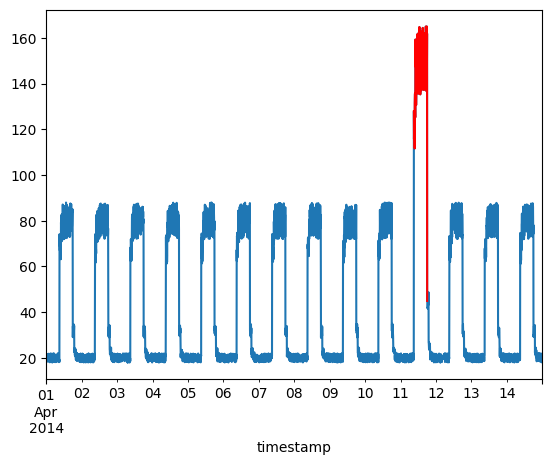

In [30]:
# 이상 데이터의 인덱스를 사용하여 해당하는 부분 데이터프레임을 선택합니다.
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

# 그래프를 그리기 위한 Figure와 Axes 객체를 생성합니다.
fig, ax = plt.subplots()

# 전체 데이터(df_daily_jumpsup)를 플롯합니다.
# legend=False는 범례를 표시하지 않도록 설정합니다.
# ax=ax는 특정 Axes 객체에 그래프를 그리도록 설정합니다.
df_daily_jumpsup.plot(legend=False, ax=ax)

# 이상 데이터(df_subset)를 플롯합니다.
# legend=False는 범례를 표시하지 않도록 설정합니다.
# ax=ax는 특정 Axes 객체에 그래프를 그리도록 설정합니다.
# color="r"는 이상 데이터를 빨간색으로 표시합니다.
df_subset.plot(legend=False, ax=ax, color="r")

plt.show()